In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, notebook
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
sly4_6 = np.loadtxt("./sly4-1e+6.table")

# Boson

In [3]:
G = 6.674e-11 
Msun = 1.98855e30
C = 299792458
hbar = 1.0545718e-34
mu = 1.660539e-27
mn = 1.674927e-27

r0 = (G*Msun)/(C*C)
rho0 = Msun/(r0*r0*r0)
p0 = (G*Msun*Msun)/(r0*r0*r0*r0)
phi0 = (C*C)/G

sly_p   = sly4_6[:,3]/p0 * (1.78266192e15*C*C) 
sly_rho = sly4_6[:,4]/rho0 * (1.78266192e15)

def eos_rho(p):
    return np.interp(p,sly_p,sly_rho)

def eos_p(rho):
    return np.interp(rho,sly_rho,sly_p)

def F_m(r,p):
    return 4.*np.pi*r*r*eos_rho(p)

def F_p(r,m,p):
    return -1.*(m+4.*np.pi*r*r*r*p)*(p+eos_rho(p))/(r*(r-2.*m))

def lbd(r,m):
    return -np.log(1.-2.*m/r)

def FY_F(r,m,p,rho,y,h):
    h = F_p(r,m,p)*h
    drhodp = \
    (-eos_rho(p+2*h)+8*eos_rho(p+h)-8*eos_rho(p-h)+eos_rho(p-2*h))/(12.*h)
    return (
        y*y + y*np.exp(lbd(r,m))*(1+4*np.pi*r*(p-rho))
        +r*r*(
            -6*np.exp(lbd(r,m))/(r*r)
            +4*np.pi*np.exp(lbd(r,m))*
            (5.*rho+9.*p+(p+rho)*( drhodp ))
            -(-2.*F_p(r,m,p)/(p+rho))**2
        ))/(-r)

def fun_eos(p,kapa0,gama0,kapa,gama):
    return (kapa0*(p)**gama0 + kapa*p**gama)

def fun_m(r,p,kapa0,gama0,kapa,gama):
    return 4.*np.pi*r*r*fun_eos(p,kapa0,gama0,kapa,gama)

def fun_p(r,m,p,kapa0,gama0,kapa,gama):
    return -1.*(m+4.*np.pi*r*r*r*p)*(p+fun_eos(p,kapa0,gama0,kapa,gama))/(r*(r-2.*m))

def Y_F(r,m,p,rho,y,kapa0,gama0,kapa,gama):
    return (
        y*y + y*np.exp(lbd(r,m))*(1+4*np.pi*r*(p-rho))
        +r*r*(
            -6*np.exp(lbd(r,m))/(r*r)
            +4*np.pi*np.exp(lbd(r,m))*
            (5.*rho+9.*p+(p+rho)*( kapa0*gama0*p**(gama0-1.)+kapa*gama*p**(gama-1.) ))
            -(-2.*fun_p(r,m,p,kapa0,gama0,kapa,gama)/(p+rho))**2
        ))/(-r)

def hybridCB_sly(CB,con,pc0):

    h = 1e-2
    rc = 1e-6
    rmax = 30

    gama = 1.
    kapa = 3.
    gama0 = 0.5
    kapa0 = CB

    rhoc0 = kapa0*pc0**gama0 + kapa*pc0**gama
    p0  = pc0
    m0  = 4.*np.pi*rc*rc*rc*rhoc0/3.

    rt = np.arange(rc,rmax,h)
    mt   = np.zeros(len(rt))
    pt   = np.zeros(len(rt))
    rhot = np.zeros(len(rt))
    yt   = np.zeros(len(rt))

    p = p0
    m = m0
    y = 2.
    rho = rhoc0
    check = 0
    conm = 0

    for j in range(len(rt)) :
        
        r = rt[j]

        if( r>=con and check==0 ):
            check = 1
            conm = m
            y = y + ( -(CB*p**0.5 + 3.*p**1.) + rho )/( p+m/(4.*np.pi*r*r*r) )
            
        elif (r<con):
            yk = h*Y_F(r, m, p, rho, y, kapa0, gama0, kapa, gama)
            y = y + yk
            

        else:
            yk = h*FY_F(r, m, p, rho, y,h)
            y = y + yk


        if(r<con):
            mk = h*fun_m(r,p,kapa0,gama0,kapa,gama)
            pk = h*fun_p(r,m,p,kapa0,gama0,kapa,gama)
            
            m = m + mk
            p = p + pk
            rho = fun_eos(p,kapa0,gama0,kapa,gama)

        else:
            mk = h*F_m(r,p)
            pk = h*F_p(r,m,p)

            m = m + mk
            p = p + pk
            rho = eos_rho(p)
        
        if( p<=0 or p==0 ):
            R0 = rt[j-1]
            M0 = mt[j-1]
            y  = yt[j-1]
            break    
        
        mt[j] = m
        pt[j] = p
        yt[j] = y
        rhot[j] = rho

    try:M0
    except NameError: M0 = None
    try:R0
    except NameError: R0 = None
    try:y
    except NameError: y = None

    if( (M0 != None) and (R0 != None) and (y != None) and ( R0 >= con ) ):
        Cc = M0/R0
        k2 = \
        (8.*(1.-2.*Cc)*(1.-2.*Cc)*Cc*Cc*Cc*Cc*Cc*(2.+2.*Cc*(-1.+y)-y))/ \
        (5.*(2.*Cc*
            (6.+Cc*Cc*(26.-22.*y)-3.*y+4.*Cc*Cc*Cc*Cc*(1+y)+3.*Cc*(-8.+5.*y)+Cc*Cc*Cc*(-4.+6.*y))
            -3.*(1.-2.*Cc)*(1.-2.*Cc)*(2.+2.*Cc*(-1.+y)-y)*np.log(1./(1.-2.*Cc))
            ))
        Lambda = 2./3.*k2/(Cc*Cc*Cc*Cc*Cc)
        if( k2<0 ):
            return None, None, None, None
        else:
            return M0, R0*1.47664, Lambda, ((conm)/M0)
    else:
        return None, None, None, None

In [4]:
a_cb_list = [  8  ]  #rw
a_cb_minp = [ -6.0  ] 
a_cb_maxp = [ -2.5  ]
a_cb_mass = []
a_cb_radi = []
a_cb_lamb = []
a_cb_rbm  = []
simps     = 100


for j in notebook.tqdm_notebook(range(len(a_cb_list))):
    press = np.power(10,np.linspace( a_cb_maxp[j], a_cb_minp[j], simps))
    mass = np.zeros(len(press))
    radius = np.zeros(len(press))
    lamb = np.zeros(len(press))
    bm   = np.zeros(len(press))

    for i in notebook.tqdm_notebook(range(len(press))):
        mass[i],radius[i],lamb[i],bm[i] = hybridCB_sly(0.035,a_cb_list[j]/1.47664,press[i])
    a_cb_mass.append(mass)
    a_cb_radi.append(radius)
    a_cb_lamb.append(lamb)
    a_cb_rbm.append(bm)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

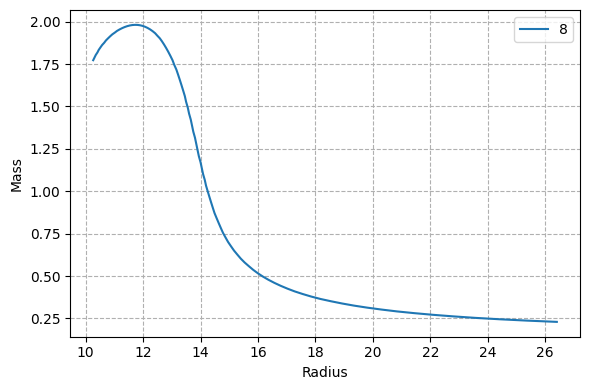

In [5]:
plt.figure(facecolor='white',dpi=100)

for i in range( len(a_cb_list) ):
    radi  = a_cb_radi[i]
    mass  = a_cb_mass[i]
    label = a_cb_list[i]
    plt.plot(radi,mass,label=str( label ))

    
plt.ylabel("Mass")
plt.xlabel("Radius")   
plt.legend()
plt.grid(ls='--')
plt.tight_layout()

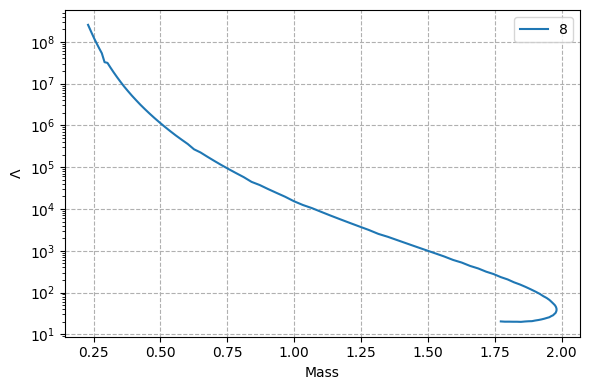

In [6]:
plt.figure(facecolor='white',dpi=100)

for i in range( len(a_cb_list) ):

    lamb  = a_cb_lamb[i]
    mass  = a_cb_mass[i]
    label = a_cb_list[i]
    plt.plot(mass,lamb,label=str( label ))

    
plt.xlabel("Mass")
plt.ylabel("$\Lambda$")  
plt.yscale('log')
plt.legend()
plt.grid(ls='--')
plt.tight_layout()

In [7]:
smass = 1.7

for i in range( len(a_cb_list) ):
    radi  = a_cb_radi[i]
    lamb  = a_cb_lamb[i]
    mass  = a_cb_mass[i]
    rbm   = a_cb_rbm[i]
    m = []
    r = []
    l = []
    bm = []
    for j in range(len(mass)):
        if(np.isnan(mass[j])==False and np.isnan(radi[j])==False and np.isnan(lamb[j])==False and np.isnan(rbm[j])==False ):
            m = np.append(m,mass[j])
            r = np.append(r,radi[j])
            l = np.append(l,lamb[j])
            bm = np.append(bm,rbm[j])

    print( ' Mass  : ', smass )
    print( ' Rc    : ', a_cb_list[i])
    print( ' Radius: ', np.interp(smass,m,r,period=np.inf) )
    print( ' Tidal : ', np.interp(smass,m,l,period=np.inf) )
    print( ' MD/M  : ', np.interp(smass,m,bm,period=np.inf) )


 Mass  :  1.7
 Rc    :  8
 Radius:  13.19229971572799
 Tidal :  352.24915307302746
 MD/M  :  0.25561514659184575


# Neutron

In [8]:
G = 6.674e-11 
Msun = 1.98855e30
C = 299792458
hbar = 1.0545718e-34
mu = 1.660539e-27
mn = 1.674927e-27

r0 = (G*Msun)/(C*C)
rho0 = Msun/(r0*r0*r0)
p0 = (G*Msun*Msun)/(r0*r0*r0*r0)
phi0 = (C*C)/G

sly_p   = sly4_6[:,3]/p0 * (1.78266192e15*C*C) 
sly_rho = sly4_6[:,4]/rho0 * (1.78266192e15)

def eos_rho(p):
    return np.interp(p,sly_p,sly_rho)

def eos_p(rho):
    return np.interp(rho,sly_rho,sly_p)

def F_m(r,p):
    return 4.*np.pi*r*r*eos_rho(p)

def F_p(r,m,p):
    return -1.*(m+4.*np.pi*r*r*r*p)*(p+eos_rho(p))/(r*(r-2.*m))

def lbd(r,m):
    return -np.log(1.-2.*m/r)

def FY_F(r,m,p,rho,y,h):
    h = F_p(r,m,p)*h
    drhodp = \
    (-eos_rho(p+2*h)+8*eos_rho(p+h)-8*eos_rho(p-h)+eos_rho(p-2*h))/(12.*h)
    return (
        y*y + y*np.exp(lbd(r,m))*(1+4*np.pi*r*(p-rho))
        +r*r*(
            -6*np.exp(lbd(r,m))/(r*r)
            +4*np.pi*np.exp(lbd(r,m))*
            (5.*rho+9.*p+(p+rho)*( drhodp ))
            -(-2.*F_p(r,m,p)/(p+rho))**2
        ))/(-r)

def fun_eos(p,kapa0,gama0,kapa,gama):
    return (kapa0*(p)**gama0 + kapa*p**gama)

def fun_m(r,p,kapa0,gama0,kapa,gama):
    return 4.*np.pi*r*r*fun_eos(p,kapa0,gama0,kapa,gama)

def fun_p(r,m,p,kapa0,gama0,kapa,gama):
    return -1.*(m+4.*np.pi*r*r*r*p)*(p+fun_eos(p,kapa0,gama0,kapa,gama))/(r*(r-2.*m))

def Y_F(r,m,p,rho,y,kapa0,gama0,kapa,gama):
    return (
        y*y + y*np.exp(lbd(r,m))*(1+4*np.pi*r*(p-rho))
        +r*r*(
            -6*np.exp(lbd(r,m))/(r*r)
            +4*np.pi*np.exp(lbd(r,m))*
            (5.*rho+9.*p+(p+rho)*( kapa0*gama0*p**(gama0-1.)+kapa*gama*p**(gama-1.) ))
            -(-2.*fun_p(r,m,p,kapa0,gama0,kapa,gama)/(p+rho))**2
        ))/(-r)

def hybridCN_sly(CB,con,pc0):
    h = 1e-2
    rc = 1e-6
    rmax = 50

    gama = 1.
    kapa = 3.
    gama0 = 0.5
    kapa0 = CB

    rhoc0 = kapa0*pc0**gama0 + kapa*pc0**gama
    p0  = pc0
    m0  = 4.*np.pi*rc*rc*rc*rhoc0/3.

    rt = np.arange(rc,rmax,h)
    mt   = np.zeros(len(rt))
    pt   = np.zeros(len(rt))
    rhot = np.zeros(len(rt))
    yt   = np.zeros(len(rt))

    p = p0
    m = m0
    y = 2.
    rho = rhoc0
    check = 0
    conm = 0

    for j in range(len(rt)) :
        
        r = rt[j]

        if( r>=con and check==0 ):
            check = 1
            conm = m
            y = y + ( (CB*p**0.5 + 3.*p**1.) - rho )/( p+m/(4.*np.pi*r*r*r) )
            
        elif (r<con):
            yk = h*FY_F(r, m, p, rho, y,h)
            y = y + yk
            
        else:
            yk = h*Y_F(r, m, p, rho, y, kapa0, gama0, kapa, gama) 
            y = y + yk


        if(r<con):
            mk = h*F_m(r,p)
            pk = h*F_p(r,m,p)

            m = m + mk
            p = p + pk
            rho = eos_rho(p)

        else:
            mk = h*fun_m(r,p,kapa0,gama0,kapa,gama)
            pk = h*fun_p(r,m,p,kapa0,gama0,kapa,gama)
            
            m = m + mk
            p = p + pk
            rho = fun_eos(p,kapa0,gama0,kapa,gama)
            
        
        if( np.isnan(np.sqrt(p)**2)==True or p==0 ):
            R0 = rt[j-1]
            M0 = mt[j-1]
            y  = yt[j-1]
            break    
        
        mt[j] = m
        pt[j] = p
        yt[j] = y
        rhot[j] = rho
    
    try:M0
    except NameError: M0 = None
    try:R0
    except NameError: R0 = None
    try:y
    except NameError: y = None

    if( (M0 != None) and (R0 != None) and (y != None) and ( R0 >= con ) ):
        Cc = M0/R0
        k2 = \
        (8.*(1.-2.*Cc)*(1.-2.*Cc)*Cc*Cc*Cc*Cc*Cc*(2.+2.*Cc*(-1.+y)-y))/ \
        (5.*(2.*Cc*
            (6.+Cc*Cc*(26.-22.*y)-3.*y+4.*Cc*Cc*Cc*Cc*(1+y)+3.*Cc*(-8.+5.*y)+Cc*Cc*Cc*(-4.+6.*y))
            -3.*(1.-2.*Cc)*(1.-2.*Cc)*(2.+2.*Cc*(-1.+y)-y)*np.log(1./(1.-2.*Cc))
            ))
        Lambda = 2./3.*k2/(Cc*Cc*Cc*Cc*Cc)
        if( k2<0 ):
            return None, None, None, None
        else:
            return M0, R0*1.47664, Lambda, ((M0-conm)/M0)
    else:
        return None, None, None, None

In [9]:
a_cn_list = [  10.7]
a_cn_minp = [ - 6.0]
a_cn_maxp = [ - 2.5]
a_cn_mass = []
a_cn_radi = []
a_cn_lamb = []
a_cn_rbm  = []
simps     = 100


for j in notebook.tqdm_notebook(range(len(a_cn_list))):
    press = np.power(10,np.linspace( a_cn_maxp[j], a_cn_minp[j], simps))
    mass = np.zeros(len(press))
    radius = np.zeros(len(press))
    lamb = np.zeros(len(press))
    rbm = np.zeros(len(press))

    for i in notebook.tqdm_notebook(range(len(press))):
        mass[i],radius[i],lamb[i],rbm[i] = hybridCN_sly(0.035,a_cn_list[j]/1.47664,press[i])
    a_cn_mass.append(mass)
    a_cn_radi.append(radius)
    a_cn_lamb.append(lamb)
    a_cn_rbm.append(rbm)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

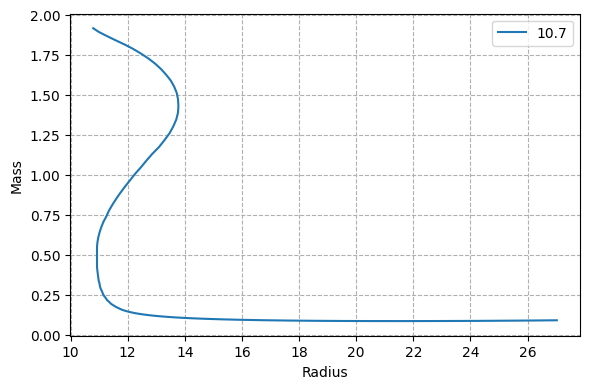

In [10]:
plt.figure(facecolor='white',dpi=100)

for i in range( len(a_cn_list) ):
    radi  = a_cn_radi[i]
    mass  = a_cn_mass[i]
    label = a_cn_list[i]
    plt.plot(radi,mass,label=str( label ))


plt.ylabel("Mass")
plt.xlabel("Radius") 
plt.legend()
plt.grid(ls='--')
plt.tight_layout()

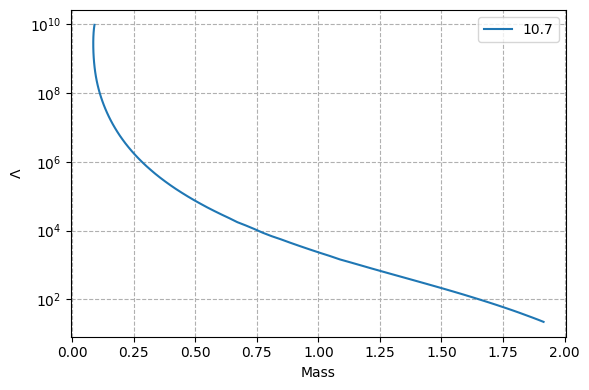

In [11]:
plt.figure(facecolor='white',dpi=100)

for i in range( len(a_cn_list) ):

    lamb  = a_cn_lamb[i]
    mass  = a_cn_mass[i]
    label = a_cn_list[i]
    plt.plot(mass,lamb,label=str( label ))

    
plt.xlabel("Mass")
plt.ylabel("$\Lambda$") 
plt.yscale('log')
plt.legend()
plt.grid(ls='--')
plt.tight_layout()

In [12]:
smass = 1.7

for i in range( len(a_cn_list) ):
    radi  = a_cn_radi[i]
    lamb  = a_cn_lamb[i]
    mass  = a_cn_mass[i]
    rbm   = a_cn_rbm[i]
    m = []
    r = []
    l = []
    bm = []
    for j in range(len(mass)):
        if(np.isnan(mass[j])==False and np.isnan(radi[j])==False and np.isnan(lamb[j])==False and np.isnan(rbm[j])==False ):
            m = np.append(m,mass[j])
            r = np.append(r,radi[j])
            l = np.append(l,lamb[j])
            bm = np.append(bm,rbm[j])

    print( ' Mass  : ', smass )
    print( ' Rc    : ', a_cn_list[i])
    print( ' Radius: ', np.interp(smass,m,r,period=np.inf) )
    print( ' Tidal : ', np.interp(smass,m,l,period=np.inf) )
    print( ' MD/M  : ', np.interp(smass,m,bm,period=np.inf) )


 Mass  :  1.7
 Rc    :  10.7
 Radius:  12.913801360997537
 Tidal :  78.20897228727286
 MD/M  :  0.015401790520794663
